# Inference Pipeline

In [ ]:
import sys
import torch

from transformers import DetrImageProcessor, DetrForObjectDetection
from PIL import Image
from pathlib import Path

import matplotlib.pyplot as plt
import matplotlib.patches as patches
import pandas as pd

In [3]:
%matplotlib inline

## Import NABirds Dataset
Use provided module of NABirds Dataset to import all required data.  
**Note:** Replace `<NABirds_root>` with the absolute path to the NABirds root directory.

In [ ]:
# ---------- IMPORT NABRIDS DATASET ----------
# local bird image data-set paths
NABIRDS_DATA_SET_DIR = Path("<NABirds_root>")
NABIRDS_DATA_SET_IMAGES = NABIRDS_DATA_SET_DIR / "images"
NABIRDS_DATA_SET_PYTHON_FILE = NABIRDS_DATA_SET_DIR / "nabirds.py"

# total number of images
NABIRDS_IMAGE_COUNT = 0

# make nabirds.py module available to sys path
sys.path.append(str(NABIRDS_DATA_SET_DIR.parent))

# check if required content directories / files exist
if NABIRDS_DATA_SET_DIR.is_dir():
    print(f"[*] Found '{NABIRDS_DATA_SET_DIR}' directory!")
else:
    print(f"[!] '{NABIRDS_DATA_SET_DIR}' data-set directory does not exist at specified location!")

if NABIRDS_DATA_SET_IMAGES.is_dir():
    print(f"[*] Found '{NABIRDS_DATA_SET_IMAGES}' image directory!")

    NABIRDS_IMAGE_COUNT = len(list(NABIRDS_DATA_SET_IMAGES.glob('*/*.jpg')))
    print(f"[*] The 'NABirds' data-set consists of {NABIRDS_IMAGE_COUNT} images")
else:
    print(f"[!] '{NABIRDS_DATA_SET_IMAGES}' data-set image directory does not exist at specified location!")

if NABIRDS_DATA_SET_PYTHON_FILE.is_file():
    print(f"[*] Found '{NABIRDS_DATA_SET_PYTHON_FILE}' Python-script!")
else:
    print(f"[!] '{NABIRDS_DATA_SET_PYTHON_FILE}' Python-script does not exist at specified location!")

if not Path(NABIRDS_DATA_SET_DIR / "nabirds.py").exists():
    print("[!] Cannot import nabirds module because the file does not exist!")
else:
    try:
        from nabirds import nabirds
        print("[*] Successfully imported 'nabirds' module!")
    except Exception as ex:
        print(f"[!] Failed to import 'nabirds' module with following error: {ex}")

In [7]:
# setup some dictionary helper
image_paths = nabirds.load_image_paths(NABIRDS_DATA_SET_DIR) # image-id: path
bounding_boxes = nabirds.load_bounding_box_annotations(NABIRDS_DATA_SET_DIR) # image-id: bounding-box coordinates
bird_class_labels = nabirds.load_image_labels(NABIRDS_DATA_SET_DIR) # image-id - class-id
bird_class_names = nabirds.load_class_names(NABIRDS_DATA_SET_DIR) # class-id - class-name

### Intersection of Union (IoU)
Compute the IoU with following formular:

$$IoU = \frac{\text{area of overlap}}{\text{area of union}}$$

For further information see: https://pyimagesearch.com/2016/11/07/intersection-over-union-iou-for-object-detection/

Furthermore, categorize the computed IoU into following classes: excellent, perfect, very good, good, acceptable and poor.

In [8]:
def compute_iou(bb_target, bb_pred):
    xt_s, yt_s, xt_e, yt_e = bb_target
    xp_s, yp_s, xp_e, yp_e = bb_pred

    # intersection rectangle coordinates
    xi_s = max(xt_s, xp_s)
    yi_s = max(yt_s, yp_s)
    xi_e = min(xt_e, xp_e)
    yi_e = min(yt_e, yp_e)

    # no overlapping at all
    if xi_e < xi_s or yi_e < yi_s:
        return 0.0

    # area intersection rectangle
    a_i = abs(xi_e - xi_s) * abs(yi_e - yi_s)

    # area of both rectangles
    a_t = abs(xt_e - xt_s) * abs(yt_e - yt_s)
    a_p = abs(xp_e - xp_s) * abs(yp_e - yp_s)
    a_u = a_t + a_p - a_i

    return a_i / a_u

def label_iou(iou):
    if iou == 1:
        return "excellent"
    elif iou > .9:
        return "perfect"
    elif iou > .8:
        return "very good"
    elif iou > .7:
        return "good"
    elif iou > .5:
        return "acceptable"

    return "poor"

### Model Inference
Below cell iterates over `MAX_PROCESSED_IMAGES` images of the NABirds dataset and compares the predicted bounding box with the target bounding box as defined in the dataset. The results are stored in an array for further processing.

In [15]:
MAX_PROCESSED_IMAGES = 1000

In [10]:
def predict_bounding_boxes(image_path, verboseOutput=False):
    image = Image.open(image_path)
    
    # you can specify the revision tag if you don't want the timm dependency
    processor = DetrImageProcessor.from_pretrained("facebook/detr-resnet-50", revision="no_timm")
    model = DetrForObjectDetection.from_pretrained("facebook/detr-resnet-50", revision="no_timm")
    
    inputs = processor(images=image, return_tensors="pt")
    outputs = model(**inputs)

    # convert outputs (bounding boxes and class logits) to COCO API
    # let's only keep detections with score > 0.9
    target_sizes = torch.tensor([image.size[::-1]])
    results = processor.post_process_object_detection(outputs, target_sizes=target_sizes, threshold=0.9)[0]
    
    if verboseOutput:
        for score, label, box in zip(results["scores"], results["labels"], results["boxes"]):
            box = [round(i, 2) for i in box.tolist()]
            print(
                    f"Detected {model.config.id2label[label.item()]} with confidence "
                    f"{round(score.item(), 3)} at location {box}"
            )

    return results

In [17]:
ious = []
quality = []
processed_image_ids = []
processed_images = []
predicted_bboxes = []
target_bboxes = []
not_predicted_images = []

counter = 0

for image_id, image_path in image_paths.items():
    image_path = NABIRDS_DATA_SET_IMAGES / image_path

    # annotated bounding box
    target_bounding_box = list(bounding_boxes[image_id])
    if not target_bounding_box:
        continue

    x, y, w, h = target_bounding_box
    target_bounding_box = (x, y, x+w, y+h)

    if counter % 10 == 0:
        verboseOutput = True

    if verboseOutput:
        print("-------------------------------------------------------------")
        print(f"[+] Target bounding box: {target_bounding_box}")
    
    # predict bounding box
    prediction_result = predict_bounding_boxes(image_path, verboseOutput)

    # continue with next image if no bounding box was predicted
    if len(prediction_result["boxes"]) < 1:
        print("[!] Failed to predict a bounding box for the current image.")
        not_predicted_images.append(image_path)
        continue

    # each NABirds photograph shows a single bird only --> if this model predicts more than one bird
    # ensure to only take the bounding box with the highest confidence
    idx_max_score = torch.argmax(prediction_result["scores"])
    predicted_bounding_box = prediction_result["boxes"][idx_max_score].tolist()

    # compare predicted and annotated bounding box using Intersection over Union (IoU)
    iou = compute_iou(target_bounding_box, predicted_bounding_box)

    if verboseOutput:
        print(f"[+] Computed IoU: {iou:.2f}")

    processed_image_ids.append(image_id)
    processed_images.append(image_path)
    predicted_bboxes.append(predicted_bounding_box)
    target_bboxes.append(target_bounding_box)
    ious.append(iou)
    quality.append(label_iou(iou))

    if counter == MAX_PROCESSED_IMAGES:
        break
    counter += 1

    verboseOutput = False

-------------------------------------------------------------
[+] Target bounding box: (365, 114, 648, 567)
Detected bird with confidence 0.999 at location [387.01, 144.74, 638.82, 552.91]
[+] Computed IoU: 0.80
-------------------------------------------------------------
[+] Target bounding box: (106, 112, 554, 399)
Detected bird with confidence 0.999 at location [105.92, 118.57, 548.98, 400.05]
[+] Computed IoU: 0.96
-------------------------------------------------------------
[+] Target bounding box: (373, 61, 998, 510)
Detected bird with confidence 0.991 at location [400.0, 89.37, 992.98, 395.87]
[+] Computed IoU: 0.65
-------------------------------------------------------------
[+] Target bounding box: (390, 176, 718, 468)
Detected bird with confidence 1.0 at location [419.38, 195.79, 669.42, 446.81]
[+] Computed IoU: 0.66
-------------------------------------------------------------
[+] Target bounding box: (322, 336, 481, 610)
Detected bird with confidence 0.998 at location [

In [18]:
data = {"image_id": processed_image_ids,
        "image_path": processed_images,
        "p_bbox": predicted_bboxes,
        "t_bbox": target_bboxes,
        "iou": ious,
        "quality": [label_iou(iou) for iou in ious]}
df = pd.DataFrame(data)
df.to_csv(f"../.data/nabirds_iou_{MAX_PROCESSED_IMAGES}imgs.csv")

### Visualize evaluation results

In [ ]:
# note: uncomment below line to read in stored dataframe
# df = pd.read_csv(f"../.data/nabirds_iou_{MAX_PROCESSED_IMAGES}imgs.csv")

#### Distribution of Model Inference Quality

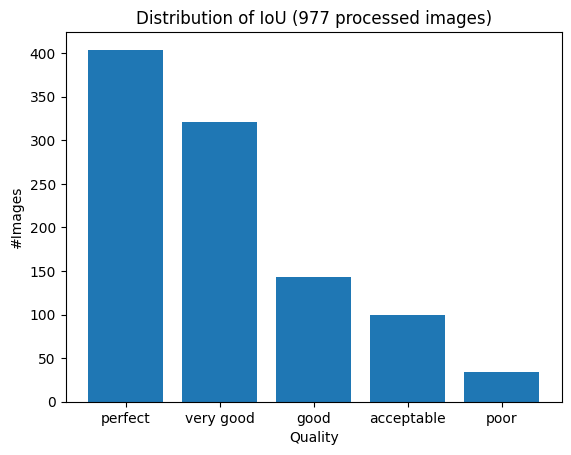

In [24]:
iou_quality = df["quality"]
quality_value_counts = iou_quality.value_counts()

fig = plt.figure()
plt.bar(quality_value_counts.index, quality_value_counts.values)
plt.ylabel("#Images")
plt.xlabel("Quality")
plt.title(f"Distribution of IoU ({MAX_PROCESSED_IMAGES - len(not_predicted_images)} processed images)")
plt.show()

#### Show some predicted - target bounding boxes
Show 4x4 images which contain the predicted and target bounding boxes including the calculated IoU.

In [20]:
def show_image_with_boxes(image_paths, predicted_bboxes, target_bboxes, ious):
    # Create figure and axes
    _, ax = plt.subplots(nrows=4, ncols=4)

    axs = ax.flatten()

    for image_path, predicted_bbox, target_bbox, iou, ax in zip(image_paths, predicted_bboxes, target_bboxes, ious, axs):
        image = Image.open(image_path)

        # Display the image
        ax.imshow(image)

        # no need to show x / y values
        ax.set_yticklabels([])
        ax.set_xticklabels([])
        ax.set_xticks([])
        ax.set_yticks([])

        # draw predicted bboxes
        box = predicted_bbox
        x_s, y_s, x_e, y_e = box
        b_w = x_e - x_s
        b_h = y_e - y_s

        # Create a Rectangle patch
        rect = patches.Rectangle((x_s, y_s), b_w, b_h, linewidth=1, edgecolor='g', facecolor='none')

        # Add the patch to the Axes
        ax.add_patch(rect)

        # draw target bboxes
        x_s, y_s, x_e, y_e = target_bbox
        b_w = x_e - x_s
        b_h = y_e - y_s

        # Create a Rectangle patch
        rect = patches.Rectangle((x_s, y_s), b_w, b_h, linewidth=1, edgecolor='b', facecolor='none')

        # Add the patch to the Axes
        ax.add_patch(rect)

        # Set computed IOU as title
        ax.title.set_text(f"IoU: {iou:.2f}")

    plt.tight_layout()
    plt.show()

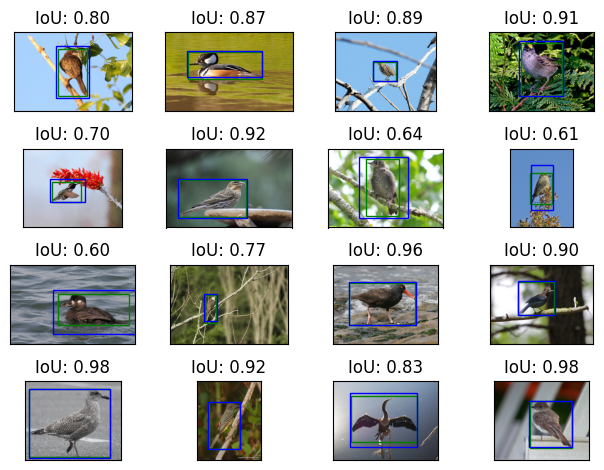

In [21]:
df_proc_imgs = df["image_path"]
df_p_bbox = df["p_bbox"]
df_t_bbox = df["t_bbox"]
df_iou = df["iou"]
show_image_with_boxes(df_proc_imgs[:16], df_p_bbox[:16], df_t_bbox[:16], df_iou[:16])